# **Processing Sequences with RNNs and CNNs**

In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path


In [2]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [12]:
tf.keras.utils.get_file(
    "ridership.zip",
    "https://github.com//veyselsapan/Machine-Learning-and-Deep-Learning/raw/main/ridership.zip",
    cache_dir=".",
    extract=True
)
path = Path("datasets/ridership.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) 
df = df.drop_duplicates()
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


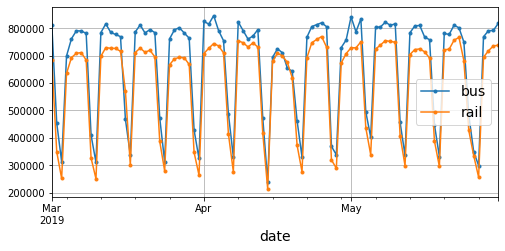

In [15]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [16]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)



# **Simple RNN**

In [17]:
tf.random.set_seed(42) 
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])


def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)



Epoch 1/500
33/33 [==============================] - 4s 42ms/step - loss: 0.0217 - mae: 0.1632 - val_loss: 0.0199 - val_mae: 0.1387
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0171 - mae: 0.1549 - val_loss: 0.0179 - val_mae: 0.1493
Epoch 3/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0167 - mae: 0.1541 - val_loss: 0.0176 - val_mae: 0.1615
Epoch 4/500
33/33 [==============================] - 3s 76ms/step - loss: 0.0165 - mae: 0.1552 - val_loss: 0.0173 - val_mae: 0.1545
Epoch 5/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0163 - mae: 0.1577 - val_loss: 0.0171 - val_mae: 0.1522
Epoch 6/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0162 - mae: 0.1570 - val_loss: 0.0174 - val_mae: 0.1421
Epoch 7/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0161 - mae: 0.1554 - val_loss: 0.0170 - val_mae: 0.1461
Epoch 8/500
33/33 [==============================] - 1s 35ms/step - loss: 0.

102808.42334032059

In [18]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)



Epoch 1/500
33/33 [==============================] - 2s 45ms/step - loss: 0.0271 - mae: 0.1723 - val_loss: 0.0051 - val_mae: 0.0756
Epoch 2/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0048 - mae: 0.0703 - val_loss: 0.0023 - val_mae: 0.0401
Epoch 3/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0037 - mae: 0.0579 - val_loss: 0.0027 - val_mae: 0.0423
Epoch 4/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0032 - mae: 0.0508 - val_loss: 0.0023 - val_mae: 0.0378
Epoch 5/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0029 - mae: 0.0468 - val_loss: 0.0024 - val_mae: 0.0402
Epoch 6/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - mae: 0.0487 - val_loss: 0.0023 - val_mae: 0.0380
Epoch 7/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0029 - mae: 0.0470 - val_loss: 0.0028 - val_mae: 0.0461
Epoch 8/500
33/33 [==============================] - 1s 38ms/step - loss: 0.

27614.45753276348

# **Deep RNNs**

In [19]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)



Epoch 1/500
33/33 [==============================] - 6s 138ms/step - loss: 0.0508 - mae: 0.2167 - val_loss: 0.0130 - val_mae: 0.1211
Epoch 2/500
33/33 [==============================] - 4s 131ms/step - loss: 0.0118 - mae: 0.1297 - val_loss: 0.0041 - val_mae: 0.0692
Epoch 3/500
33/33 [==============================] - 4s 129ms/step - loss: 0.0058 - mae: 0.0743 - val_loss: 0.0030 - val_mae: 0.0548
Epoch 4/500
33/33 [==============================] - 4s 130ms/step - loss: 0.0047 - mae: 0.0642 - val_loss: 0.0028 - val_mae: 0.0488
Epoch 5/500
33/33 [==============================] - 5s 134ms/step - loss: 0.0039 - mae: 0.0567 - val_loss: 0.0029 - val_mae: 0.0476
Epoch 6/500
33/33 [==============================] - 4s 131ms/step - loss: 0.0038 - mae: 0.0556 - val_loss: 0.0030 - val_mae: 0.0517
Epoch 7/500
33/33 [==============================] - 4s 128ms/step - loss: 0.0036 - mae: 0.0545 - val_loss: 0.0025 - val_mae: 0.0430
Epoch 8/500
33/33 [==============================] - 4s 127ms/step - 

30159.056186676025

# **Multivariate Time Series**

In [20]:


df_mulvar = df[["bus", "rail"]] / 1e6  
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar) 

mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]


train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(), 
    targets=mulvar_train["rail"][seq_length:], 
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)



Epoch 1/500
33/33 [==============================] - 2s 41ms/step - loss: 0.0386 - mae: 0.1872 - val_loss: 0.0011 - val_mae: 0.0346
Epoch 2/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0029 - mae: 0.0585 - val_loss: 0.0040 - val_mae: 0.0790
Epoch 3/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0018 - mae: 0.0435 - val_loss: 7.7056e-04 - val_mae: 0.0273
Epoch 4/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0017 - mae: 0.0407 - val_loss: 0.0010 - val_mae: 0.0362
Epoch 5/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0015 - mae: 0.0386 - val_loss: 8.1681e-04 - val_mae: 0.0306
Epoch 6/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0014 - mae: 0.0372 - val_loss: 0.0011 - val_mae: 0.0380
Epoch 7/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0014 - mae: 0.0366 - val_loss: 7.9942e-04 - val_mae: 0.0289
Epoch 8/500
33/33 [==============================] - 1s 38ms/ste

22062.301635742188

In [21]:
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 39ms/step - loss: 0.0398 - mae: 0.1953 - val_loss: 0.0073 - val_mae: 0.0998
Epoch 2/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0039 - mae: 0.0632 - val_loss: 0.0012 - val_mae: 0.0384
Epoch 3/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0027 - mae: 0.0509 - val_loss: 0.0010 - val_mae: 0.0362
Epoch 4/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0024 - mae: 0.0488 - val_loss: 0.0018 - val_mae: 0.0491
Epoch 5/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0023 - mae: 0.0473 - val_loss: 0.0012 - val_mae: 0.0372
Epoch 6/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0022 - mae: 0.0463 - val_loss: 0.0011 - val_mae: 0.0361
Epoch 7/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0019 - mae: 0.0442 - val_loss: 8.8553e-04 - val_mae: 0.0322
Epoch 8/500
33/33 [==============================] - 1s 35ms/step - loss

25850.359350442886

# **RNN that predicts all 14 next values at once**

In [22]:
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)



Epoch 1/500
33/33 [==============================] - 2s 39ms/step - loss: 0.1250 - mae: 0.3791 - val_loss: 0.0287 - val_mae: 0.1935
Epoch 2/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0191 - mae: 0.1613 - val_loss: 0.0136 - val_mae: 0.1289
Epoch 3/500
33/33 [==============================] - 1s 36ms/step - loss: 0.0131 - mae: 0.1303 - val_loss: 0.0102 - val_mae: 0.1113
Epoch 4/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0108 - mae: 0.1164 - val_loss: 0.0083 - val_mae: 0.1009
Epoch 5/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0093 - mae: 0.1068 - val_loss: 0.0071 - val_mae: 0.0931
Epoch 6/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0083 - mae: 0.0996 - val_loss: 0.0061 - val_mae: 0.0862
Epoch 7/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0076 - mae: 0.0941 - val_loss: 0.0055 - val_mae: 0.0811
Epoch 8/500
33/33 [==============================] - 1s 33ms/step - loss: 0.

35017.30412244797

In [24]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))


def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)



Epoch 1/500
33/33 [==============================] - 3s 78ms/step - loss: 0.0615 - mae: 0.2571 - val_loss: 0.0164 - val_mae: 0.1355
Epoch 2/500
33/33 [==============================] - 3s 69ms/step - loss: 0.0115 - mae: 0.1159 - val_loss: 0.0097 - val_mae: 0.1006
Epoch 3/500
33/33 [==============================] - 2s 63ms/step - loss: 0.0077 - mae: 0.0898 - val_loss: 0.0074 - val_mae: 0.0841
Epoch 4/500
33/33 [==============================] - 1s 41ms/step - loss: 0.0063 - mae: 0.0783 - val_loss: 0.0063 - val_mae: 0.0760
Epoch 5/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0056 - mae: 0.0720 - val_loss: 0.0054 - val_mae: 0.0677
Epoch 6/500
33/33 [==============================] - 1s 42ms/step - loss: 0.0053 - mae: 0.0688 - val_loss: 0.0057 - val_mae: 0.0725
Epoch 7/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0050 - mae: 0.0660 - val_loss: 0.0050 - val_mae: 0.0654
Epoch 8/500
33/33 [==============================] - 1s 41ms/step - loss: 0.

46137.58623600006

# **Deep RNNs with Layer Norm**

In [26]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)



Epoch 1/5
33/33 [==============================] - 9s 122ms/step - loss: 0.0685 - mae: 0.2614 - val_loss: 0.0177 - val_mae: 0.1386
Epoch 2/5
33/33 [==============================] - 3s 95ms/step - loss: 0.0135 - mae: 0.1350 - val_loss: 0.0138 - val_mae: 0.1215
Epoch 3/5
33/33 [==============================] - 3s 95ms/step - loss: 0.0110 - mae: 0.1201 - val_loss: 0.0119 - val_mae: 0.1122
Epoch 4/5
33/33 [==============================] - 3s 94ms/step - loss: 0.0100 - mae: 0.1112 - val_loss: 0.0106 - val_mae: 0.1062
Epoch 5/5
3/3 [==============================] - 0s 25ms/step - loss: 0.0100 - mae: 0.1036


103604.33161258698

In [27]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [28]:
custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=25)



Epoch 1/25
33/33 [==============================] - 6s 147ms/step - loss: 0.0640 - mae: 0.2523 - val_loss: 0.0189 - val_mae: 0.1446
Epoch 2/25
33/33 [==============================] - 3s 96ms/step - loss: 0.0139 - mae: 0.1406 - val_loss: 0.0147 - val_mae: 0.1250
Epoch 3/25
33/33 [==============================] - 3s 98ms/step - loss: 0.0116 - mae: 0.1251 - val_loss: 0.0127 - val_mae: 0.1162
Epoch 4/25
33/33 [==============================] - 3s 101ms/step - loss: 0.0104 - mae: 0.1153 - val_loss: 0.0115 - val_mae: 0.1091
Epoch 5/25
33/33 [==============================] - 3s 99ms/step - loss: 0.0095 - mae: 0.1075 - val_loss: 0.0109 - val_mae: 0.1050
Epoch 6/25
33/33 [==============================] - 3s 104ms/step - loss: 0.0088 - mae: 0.1016 - val_loss: 0.0103 - val_mae: 0.1017
Epoch 7/25
33/33 [==============================] - 3s 101ms/step - loss: 0.0083 - mae: 0.0964 - val_loss: 0.0094 - val_mae: 0.0970
Epoch 8/25
33/33 [==============================] - 3s 100ms/step - loss: 0.007

60914.747416973114

# **LSTMs**

In [29]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])


fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=25)



Epoch 1/25
33/33 [==============================] - 3s 25ms/step - loss: 0.0555 - mae: 0.2568 - val_loss: 0.0190 - val_mae: 0.1608
Epoch 2/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0177 - mae: 0.1614 - val_loss: 0.0182 - val_mae: 0.1461
Epoch 3/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0161 - mae: 0.1540 - val_loss: 0.0170 - val_mae: 0.1440
Epoch 4/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0152 - mae: 0.1495 - val_loss: 0.0162 - val_mae: 0.1398
Epoch 5/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0144 - mae: 0.1449 - val_loss: 0.0155 - val_mae: 0.1356
Epoch 6/25
33/33 [==============================] - 1s 24ms/step - loss: 0.0137 - mae: 0.1410 - val_loss: 0.0148 - val_mae: 0.1319
Epoch 7/25
33/33 [==============================] - 1s 23ms/step - loss: 0.0131 - mae: 0.1370 - val_loss: 0.0141 - val_mae: 0.1281
Epoch 8/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0125 - m

104122.45988845825

# **GRU**

In [31]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])


fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=25)



Epoch 1/25
33/33 [==============================] - 3s 23ms/step - loss: 0.0551 - mae: 0.2541 - val_loss: 0.0178 - val_mae: 0.1600
Epoch 2/25
33/33 [==============================] - 0s 11ms/step - loss: 0.0147 - mae: 0.1410 - val_loss: 0.0139 - val_mae: 0.1301
Epoch 3/25
33/33 [==============================] - 0s 11ms/step - loss: 0.0119 - mae: 0.1267 - val_loss: 0.0124 - val_mae: 0.1194
Epoch 4/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0107 - mae: 0.1173 - val_loss: 0.0113 - val_mae: 0.1131
Epoch 5/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0099 - mae: 0.1113 - val_loss: 0.0106 - val_mae: 0.1091
Epoch 6/25
33/33 [==============================] - 0s 11ms/step - loss: 0.0094 - mae: 0.1072 - val_loss: 0.0102 - val_mae: 0.1060
Epoch 7/25
33/33 [==============================] - 0s 11ms/step - loss: 0.0090 - mae: 0.1041 - val_loss: 0.0097 - val_mae: 0.1033
Epoch 8/25
33/33 [==============================] - 0s 12ms/step - loss: 0.0087 - m

84083.51242542267

# **One-Dimensional Convolutional Layers to Process Sequences**

In [32]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))


fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=25)

Epoch 1/25
31/31 [==============================] - 6s 28ms/step - loss: 0.0568 - mae: 0.2672 - val_loss: 0.0186 - val_mae: 0.1602
Epoch 2/25
31/31 [==============================] - 0s 12ms/step - loss: 0.0151 - mae: 0.1440 - val_loss: 0.0150 - val_mae: 0.1327
Epoch 3/25
31/31 [==============================] - 0s 12ms/step - loss: 0.0124 - mae: 0.1304 - val_loss: 0.0134 - val_mae: 0.1230
Epoch 4/25
31/31 [==============================] - 0s 11ms/step - loss: 0.0110 - mae: 0.1204 - val_loss: 0.0120 - val_mae: 0.1166
Epoch 5/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0099 - mae: 0.1128 - val_loss: 0.0109 - val_mae: 0.1110
Epoch 6/25
31/31 [==============================] - 0s 12ms/step - loss: 0.0090 - mae: 0.1066 - val_loss: 0.0100 - val_mae: 0.1060
Epoch 7/25
31/31 [==============================] - 0s 12ms/step - loss: 0.0082 - mae: 0.1007 - val_loss: 0.0091 - val_mae: 0.1009
Epoch 8/25
31/31 [==============================] - 0s 12ms/step - loss: 0.0076 - m

62786.296010017395

# **WaveNet**

In [33]:
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)



Epoch 1/5
31/31 [==============================] - 3s 35ms/step - loss: 0.0843 - mae: 0.3313 - val_loss: 0.0251 - val_mae: 0.1467
Epoch 2/5
31/31 [==============================] - 0s 13ms/step - loss: 0.0168 - mae: 0.1528 - val_loss: 0.0182 - val_mae: 0.1514
Epoch 3/5
31/31 [==============================] - 0s 13ms/step - loss: 0.0154 - mae: 0.1542 - val_loss: 0.0178 - val_mae: 0.1464
Epoch 4/5
31/31 [==============================] - 0s 13ms/step - loss: 0.0146 - mae: 0.1479 - val_loss: 0.0166 - val_mae: 0.1394
Epoch 5/5
1/1 [==============================] - 0s 65ms/step - loss: 0.0149 - mae: 0.1282


128154.33740615845

# **Wavenet Implementation**

In [34]:


class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=25)



Epoch 1/25
31/31 [==============================] - 2s 31ms/step - loss: 0.0669 - mae: 0.2812 - val_loss: 0.0198 - val_mae: 0.1503
Epoch 2/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0118 - mae: 0.1259 - val_loss: 0.0115 - val_mae: 0.1111
Epoch 3/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0079 - mae: 0.0982 - val_loss: 0.0092 - val_mae: 0.0992
Epoch 4/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0067 - mae: 0.0888 - val_loss: 0.0084 - val_mae: 0.0950
Epoch 5/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0062 - mae: 0.0839 - val_loss: 0.0079 - val_mae: 0.0910
Epoch 6/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0058 - mae: 0.0797 - val_loss: 0.0074 - val_mae: 0.0867
Epoch 7/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0055 - mae: 0.0764 - val_loss: 0.0070 - val_mae: 0.0835
Epoch 8/25
31/31 [==============================] - 0s 13ms/step - loss: 0.0052 - m

62098.35037589073